<a href="https://colab.research.google.com/github/VikaK0828/Data-Science/blob/main/Unit_6Project_Study_time_to_Exam_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ok so I basically added onto the Unit 5 Project so that is why you willl see a bunch of old, Well reused I would say better, models, but I added the new ones and they work which I am really happy about!!

In [20]:
!pip install bambi


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import bambi as bmb
from scipy.interpolate import PchipInterpolator



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
np.random.seed(42)
study_hours = np.random.normal(5, 1.5, 100)
exam_scores = 50 + (study_hours * 5) + np.random.normal(0, 10, 100)

data = pd.DataFrame({"StudyHours": study_hours, "ExamScores": exam_scores})

data.head()


,StudyHours,ExamScores
0,5.745071,64.571649
1,4.792604,69.756565
2,5.971533,76.430519
3,7.284545,78.399951
4,4.648770,71.630993


In this part, I generated synthetic data to simulate a study-exam scenario. I used a normal distribution to create study_hours, with a mean of 5 hours and a standard deviation of 1.5. Then, I created exam_scores based on a linear relationship with study hours, adding some noise to make it more riealistic. Finally, I organized the data into a DataFrame and displayed the first few rows to inspect the structure of the data.

<Axes: title={'center': 'Study Hours vs Exam Scores'}, xlabel='StudyHours', ylabel='ExamScores'>

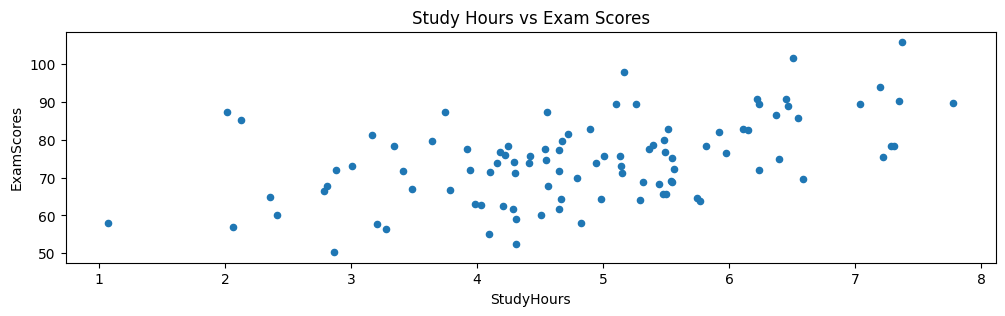

In [ ]:

data.plot(x="StudyHours", y="ExamScores", figsize=(12, 3), kind="scatter", title="Study Hours vs Exam Scores")


In this step, I created a scatter plot to visually explore the relationship between StudyHours and ExamScores. The plot helps me see how exam scores vary with the amount of time spent studying. By plotting the data points, I can quickly identify any trends, such as whether more study hours gyenerally lead to higher exam scores, and observe any outliers or patterns in the data.

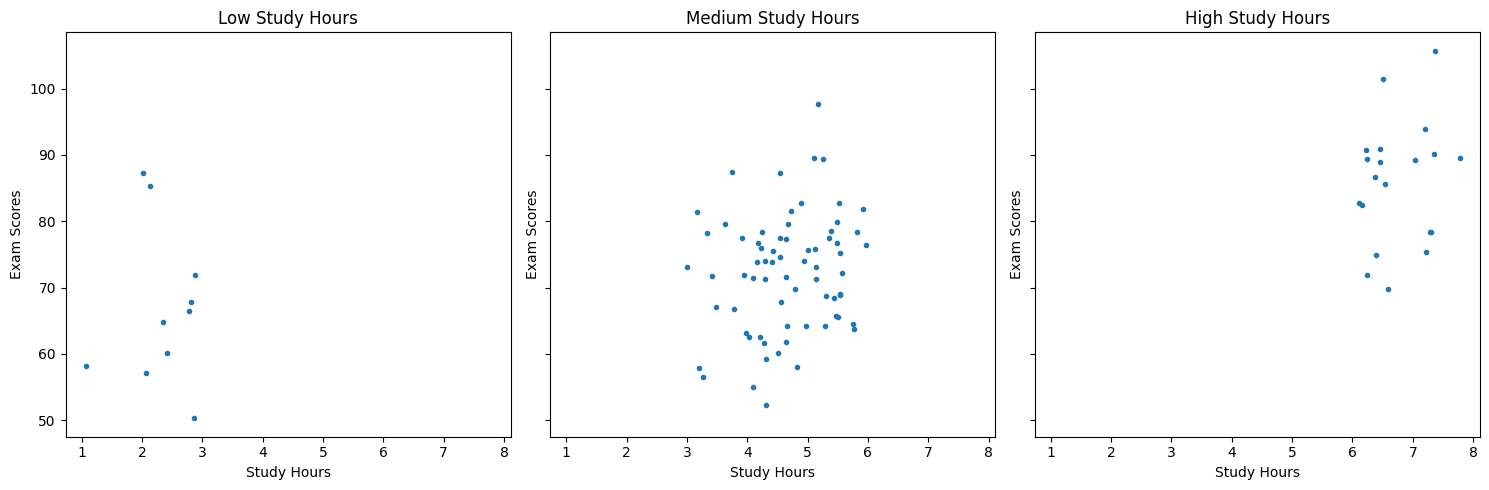

In [ ]:
data['StudyCategory'] = pd.cut(data['StudyHours'], bins=[0, 3, 6, 9], labels=['Low', 'Medium', 'High'])

study_categories = data['StudyCategory'].cat.categories

study_coords = {"StudyCategory": study_categories}

_, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax = np.ravel(ax)

for i, cat in enumerate(study_categories):
    ax[i].scatter(
        x=data.query('StudyCategory == @cat')['StudyHours'],
        y=data.query('StudyCategory == @cat')['ExamScores'],
        marker=".")
    ax[i].set_title(f"{cat} Study Hours")
    ax[i].set_xlabel("Study Hours")
    ax[i].set_ylabel("Exam Scores")

plt.tight_layout()
plt.show()


In this step, I categorized the study hours into three groups: Low, Medium, and High, based on predefined bins. This helps me analyze how the relationship between stuudy hours and exam scores differs across different levels of study time. I then created a series of scatter plots, one for each category, to visually compare the exam scores across these different study hour groups. By examining the plots, I can observe how the exam scores are distributed within each category and whether the relationship between study time and scores changes at different levels of study.

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

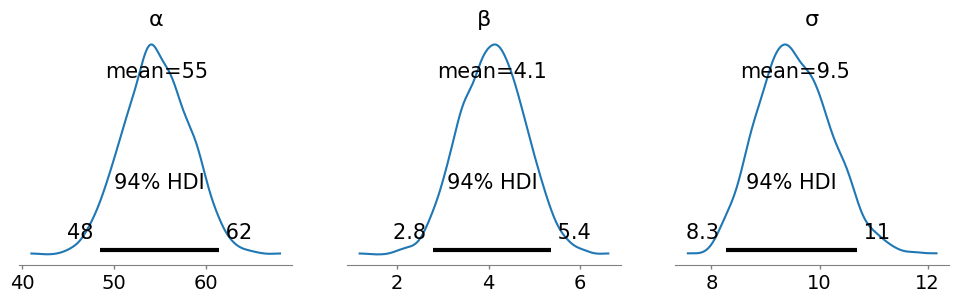

In [ ]:
with pm.Model() as model_study:

    # Priors for intercept (α) and slope (β)
    α = pm.Normal("α", mu=0, sigma=50)
    β = pm.Normal("β", mu=0, sigma=10)

    # Linear model: μ = α + β * StudyHours
    μ = pm.Deterministic("μ", α + β * data.StudyHours)

    # Prior for standard deviation (σ)
    σ = pm.HalfCauchy("σ", beta=10)

    # Likelihood: observed ExamScores
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.ExamScores)

    # Sampling from the posterior
    idata_study = pm.sample()

# Plot the posterior distributions
az.plot_posterior(idata_study, var_names=["~μ"], figsize=(12, 3))



In this step, I built a Bayesian linear regression model using PyMC. First, I defined priors for the intercept (α) and slope (β), which represent the relationship between study hours and exam scores. I used normal distributions for both parameters, with wide standard deviations to express uncertainty. Then, I modeled the exam scores (y_pred) as normally distributed around a predicted mean (μ), which was determined by a linear function of study hours. I also specified a prior for the standard deviation (σ) using a half-Cauchy distribution. After defining the model, I sampled from the posterior distribution to estimate the model parameters. Finally, I visualizeded the posterior distribution of the model's predicted mean (μ), which shows the uncertainty around the relationship between study hours and exam scores.

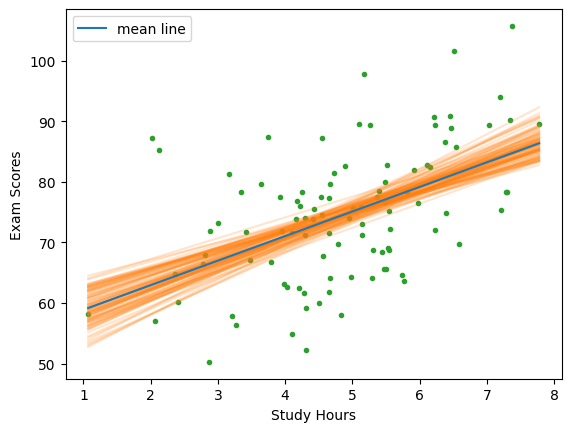

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

posterior = az.extract(idata_study, num_samples=100)

# array of x values (StudyHours) for plotting the predicted lines
x_plot = xr.DataArray(
    np.linspace(data.StudyHours.min(), data.StudyHours.max(), 50),
    dims="plot_id"
)

# I am calculating the mean prediction line using the posterior means for α and β
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

# Calculatiing the lines for each posterior sample
lines = posterior["α"] + posterior["β"] * x_plot

# Setting up ze plot
_, ax = plt.subplots()

# Plotting the predicted lines but without adding them to the legend
ax.plot(x_plot, lines.T, c="C1", alpha=0.2)  # No label for these lines

# Plotting the mean prediction line and add it to the legend
ax.plot(x_plot, mean_line, c="C0", label="mean line")

# Plotting the observed data points (StudyHours vs ExamScores) without adding to the legend
ax.plot(data.StudyHours, data.ExamScores, "C2.", zorder=-3)

# Setting labels
ax.set_xlabel("Study Hours")
ax.set_ylabel("Exam Scores")

# Removing the legend for the individual lines, only showing the mean line
plt.legend()

# Displaying the plot
plt.show()



Here, I gots 100 samples from the posterior distribution to estimate the model parameters (α and β). I then created a smooth range of study hours (x_plot) and calculated predicted exam scores using the posterior samples, including both the mean prediction line and individual posterior samples. I plotted these predicted lines with transparency to show uncertainty, added the mean line for clarity, and included the observed data points. This visualization helps to compare the model's predictions with the actual data.

Output()

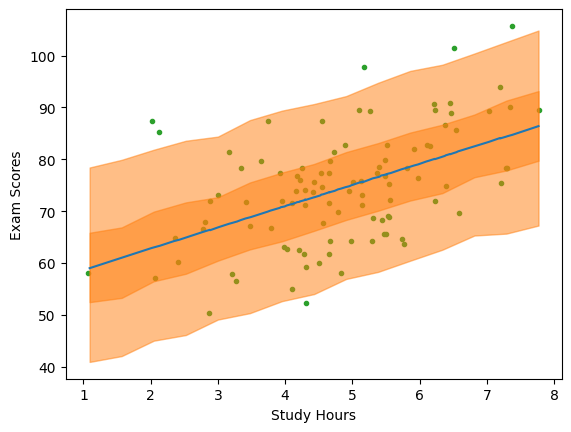

In [ ]:
from scipy.interpolate import PchipInterpolator
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Posterior predictive check
pm.sample_posterior_predictive(idata_study, model=model_study, extend_inferencedata=True)

# Calculate the mean prediction line from the posterior
mean_line = idata_study.posterior["μ"].mean(("chain", "draw"))

# Add some noise to StudyHours (similar to how we did for height)
study_hours_with_noise = np.random.normal(data.StudyHours.values, 0.01)
idx = np.argsort(study_hours_with_noise)

# Generate a smooth range of study hours for plotting
x = np.linspace(study_hours_with_noise.min(), study_hours_with_noise.max(), 15)

# Quantiles for the posterior predictive distribution
y_pred_q = idata_study.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

# Interpolate the quantiles for each posterior sample
y_hat_bounds = iter(
    [
        PchipInterpolator(study_hours_with_noise[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

# Set up the plot
_, ax = plt.subplots()

# Plot the observed data points (StudyHours vs ExamScores)
ax.plot(data.StudyHours, data.ExamScores, "C2.", zorder=-3)

# Plot the mean prediction line
ax.plot(study_hours_with_noise[idx], mean_line[idx], c="C0")

# Fill the region between the quantiles to show uncertainty
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

# Set axis labels
ax.set_xlabel("Study Hours")
ax.set_ylabel("Exam Scores")

# Display the plot
plt.show()



In this step, I didh a posterior predictive check to evaluate how well the model predicts new data based on the posterior samples. After generating predictions from the model, I added noise to the study hours for variability, then plotted the mean prediction line along with the uncertainty intervals (from the quantiles of the posterior predictive distribution). By filling the region between these quantiles, I visualized the uncertainty in the model's predictions. This plot helps assess how well the model generalizes to unseen data.

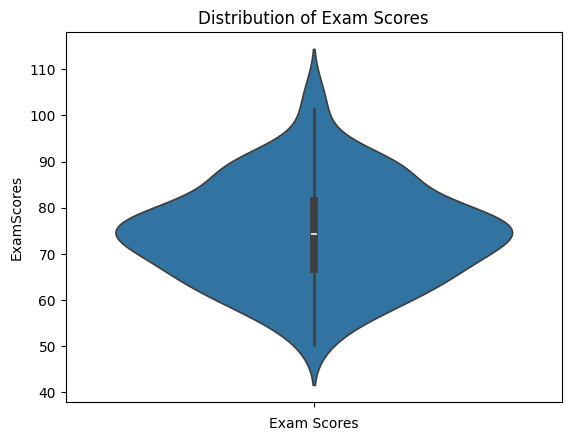

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a violin plot for Exam Scores
sns.violinplot(data.ExamScores)

# Set axis labels and title
plt.xlabel("Exam Scores")
plt.title("Distribution of Exam Scores")

# Display the plot
plt.show()



In this step, I created a violin plot to visualize the distribution of the exam scores. The violinx plot combines aspects of a box plot and a density plot, showing the distribution of the data, its spread, and potential multimodality. It provides insights into the data's skewness, central tendency, and the presence of outliers. The x-axis represents the exam scores, and the title helps contextualize the plot, focusing on the distribution of these scores.

Output()

Output()

Output()

<Axes: xlabel='y_pred'>

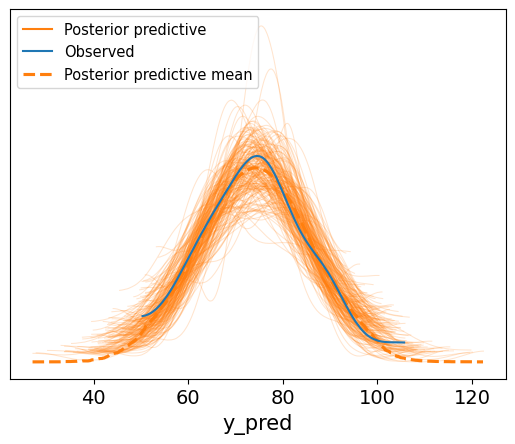

In [ ]:
import pymc as pm
import arviz as az

# Define the model
with pm.Model() as model_nh:
    # Priors for α and β
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    # The linear part of the model with exponential function
    μ = pm.Deterministic("μ", pm.math.exp(α + β * data.StudyHours))

    # Prior for σ (standard deviation)
    σ = pm.HalfNormal("σ", 10)

    # Likelihood of the observed data (ExamScores)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.ExamScores)

    # Sampling
    idata_nh = pm.sample()

    # Posterior predictive sampling
    pm.sample_posterior_predictive(idata_nh, model=model_nh, extend_inferencedata=True)

# Plot the posterior predictive check (PPC)
az.plot_ppc(idata_nh, num_pp_samples=200, colors=["C1", "C0", "C1"])



In this step, I defined a new probabilistic model using PyMC for predicting exam scores based on study hours with an exponential relationship. First, I set normal priors for the intercept (α) and slope (β), and used an exponential function for the linear relationship between studuy hours and the predicted mean (μ). I also set a half-normal prior for the standard deviation (σ), representing the noise in the data. I then sampled from the posterior distribution using PyMC's sample() function. Afterward, I performed posterior predictive sampling to assess the model's predictions against the observed exam scores.

Finally, I plotted the posterior predictive check (PPC), using az.plot_ppc() to visualize how well the model's predicted values align with the actual data. This plot helps evaluate the model's fit by comparing the observed values (ExamScores) with the range of values predicted by the model.

##Multiple lInear Model

Output()

Output()

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α       3.967  0.060   3.858    4.079      0.002    0.002     755.0     808.0   
β       0.064  0.012   0.043    0.086      0.000    0.000     755.0     974.0   
μ[0]   62.544  2.041  58.883   66.401      0.069    0.049     863.0    1075.0   
μ[1]   68.832  1.470  66.074   71.588      0.039    0.028    1397.0    1258.0   
μ[2]   72.968  1.435  70.355   75.556      0.031    0.022    2156.0    1229.0   
...       ...    ...     ...      ...        ...      ...       ...       ...   
μ[96]  65.988  1.680  62.898   69.176      0.052    0.037    1036.0    1316.0   
μ[97]  71.603  1.404  69.026   74.137      0.031    0.022    1998.0    1384.0   
μ[98]  67.024  1.591  63.885   69.871      0.047    0.033    1134.0    1307.0   
μ[99]  63.830  1.898  60.418   67.448      0.063    0.044     910.0    1125.0   
σ      42.806  5.806  32.718   53.909      0.196    0.140     897.0     868.0   

       r_hat  
α        1.0

array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

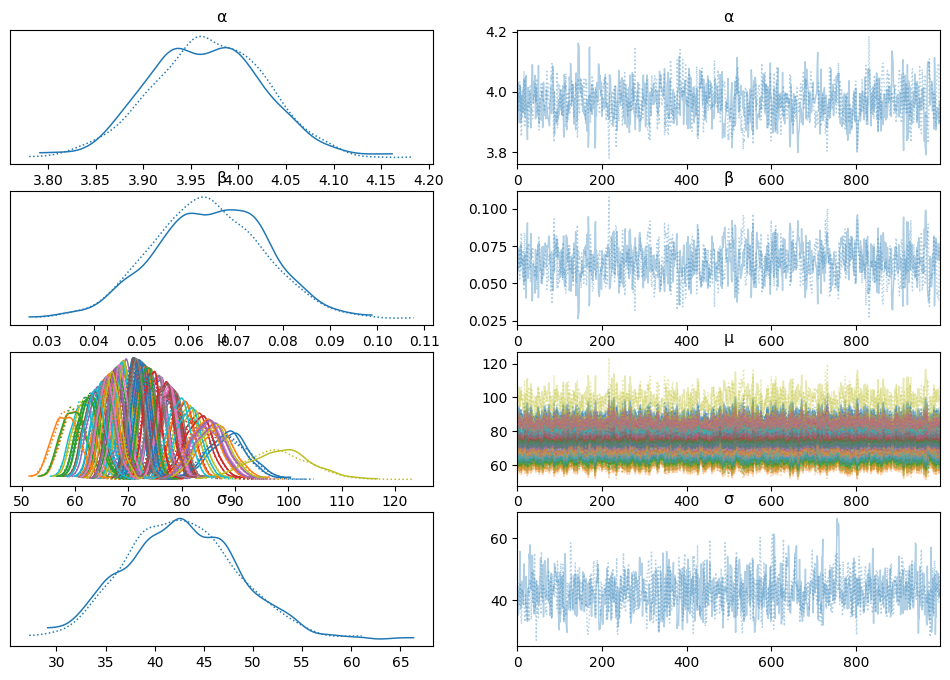

In [29]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az



# Fit the Negative Binomial model
with pm.Model() as model_nbb:
    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    # The linear part of our model (but exponentiated to ensure positivity)
    μ = pm.Deterministic("μ", pm.math.exp(α + β * data["StudyHours"]))

    # Prior for the likelihood's standard deviation (this is analogous to the dispersion parameter)
    σ = pm.HalfNormal("σ", sigma=10)

    # Likelihood: Negative Binomial
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=data["ExamScores"])

    # Sampling the posterior
    idata_nbb = pm.sample(draws=1000, chains=2, tune=1000)

# Use ArviZ to summarize the sampling results
# Get the posterior trace
trace = idata_nbb.posterior

# Display the summary of the trace
summary_stats = az.summary(idata_nbb)
print(summary_stats)

az.plot_trace(idata_nbb)



 I set up the model in PyMC, where α (alpha) is the baseline score (like if someone studied 0 hours), and β (beta) is how much the score increases for each extra hour studied. I also include σ (sigma), which controls the randomness in scores. Instead of just using a regular regression, I exponentiate the equation to make sure all predicted scores are positive (because, obvi, negative exam scores don’t make sense). Then, I fit the model using Bayesian inference, which means I sample a bunch of possible values for α, β, and σ to see what makes the most sense given the data. Finally, I check the results using ArviZ, which gives me a summary of the sampled values and lets me visualize them. This helps me compare study hours and exam scores to see if there’s a clear pattern.

Output()

<Axes: xlabel='y'>

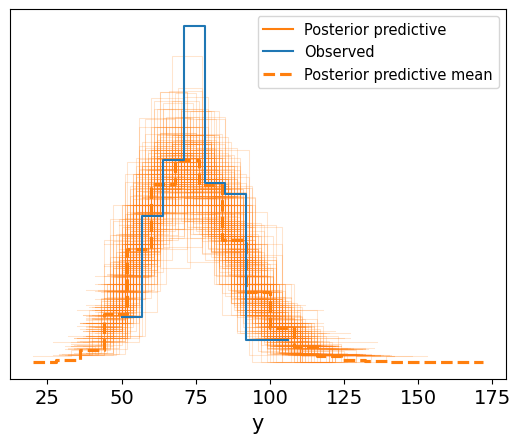

In [14]:
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

This part is all about checking how well the model actually works. The first line, pm.sample_posterior_predictive(), takes the model we already trained (model_nbb) and uses the sampld parameters (from idata_nbb) to generate new predicted exam scores. This is like asiing, "If I had new students with similar study habits, what scores would my model expect them to get?" The extend_inferencedata=True part makes ure these new predictions get added to our existing data so we can analyze them easily.

Then, az.plot_ppc() (posterior redictive check) helps visualie whether our model's predictions match the actual data. It basically plots the distribution of real scores (the ones we generated earlier) against the scores our model thinks should happen. If the two distributions line up well, that means our model is doing a good job at capturin the relationship betwen study hours and exam scores. The num_pp_samples=200 part just means we’re drawing 200 samples to get a smooth crve, and the coors=["C1", "C0", "C1"] part is just setting the colors to make the graph look nice. Overall, this step helps confirm if our model is actuagly useful or if it's just making nonsense predictuns!

Bambi Models

Output()

Output()

       Formula: ExamScores ~ StudyHours
        Family: negativebinomial
          Link: mu = log
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.2781)
            StudyHours ~ Normal(mu: 0.0, sigma: 1.8444)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 52 Axes>,
 array([[<Axes: title={'center': 'StudyHours = 1.0703823438653837'}, xlabel='StudyHours', ylabel='ExamScores'>,
         <Axes: title={'center': 'StudyHours = 1.2072810159653433'}, xlabel='StudyHours', ylabel='ExamScores'>,
         <Axes: title={'center': 'StudyHours = 1.344179688065303'}, xlabel='StudyHours', ylabel='ExamScores'>,
         <Axes: title={'center': 'StudyHours = 1.4810783601652626'}, xlabel='StudyHours', ylabel='ExamScores'>],
        [<Axes: title={'center': 'StudyHours = 1.6179770322652223'}, xlabel='StudyHours', ylabel='ExamScores'>,
         <Axes: title={'center': 'StudyHours = 1.754875704365182'}, xlabel='StudyHours', ylabel='ExamScores'>,
         <Axes: title={'center': 'StudyHours = 1.8917743764651416'}, xlabel='StudyHours', ylabel='ExamScores'>,
         <Axes: title={'center': 'StudyHours = 2.0286730485651012'}, xlabel='StudyHours', ylabel='ExamScores'>],
        [<Axes: title={'center': 'StudyHours = 2.165571720665061'},

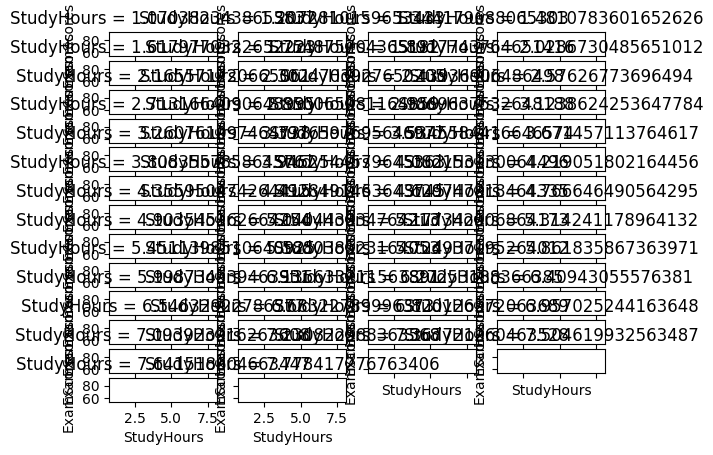

In [21]:
# Define the Negative Binomial model with Bambi
model_mlb_bmb = bmb.Model("ExamScores ~ StudyHours", data, family="negativebinomial")

# Fit the model
idata_mlb_bmb = model_mlb_bmb.fit(idata_kwargs={"log_likelihood": True})

# Display the model summary
print(model_mlb_bmb)

# Plot predictions using Bambi
bmb.interpret.plot_predictions(
    model_mlb_bmb,
    idata_mlb_bmb,
    ["StudyHours"],  # Predictor variable
    subplot_kwargs={"group": None, "panel": "StudyHours"},
    legend=False,
    fig_kwargs={"sharey": True, "sharex": True}
)



The model is defined using Bambi, with ExamScores ~ StudHours as the formula. This tells the model, "Hey, I think examscores depend on study hours", and it specifies a Negative Binomial family, which is useful when modeling count-like data with some overdispersion (some extra randomness beyond what a normal distributon would expect). After that, the model is trained (fit), and the summary is prined, which shows the estimated relationship between study hours and scores.

Finally, the last part of the code uses plot_predictions() to visualize how the model thinks exam scores change as study hours increase. It plots predicted values along with uncertainty bands to show how confident the model is in its predictions. The sttings like subplot_kwarg={"group": None, "panel": "StudyHours"} help make the graph clearer by focusing on just this one predictor, and legend=Falsekeeps things unluttered. Overall, thicode is all about seeing how well study hours predict exam scores and checking if themodel captures the trend accurately!

Distributional Models

Output()

Output()

       Formula: ExamScores ~ StudyHours
                sigma ~ StudyHours
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 74.4442, sigma: 100.9658)
            StudyHours ~ Normal(mu: 0.0, sigma: 20.0716)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_StudyHours ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


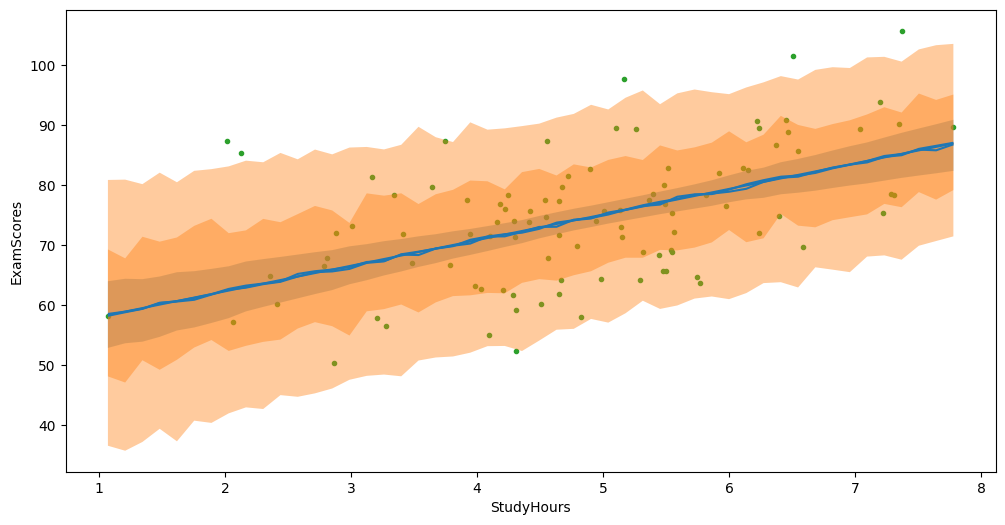

In [25]:
import pandas as pd
import numpy as np
import bambi as bmb
import matplotlib.pyplot as plt
import arviz as az


# Create the DataFrame
data = pd.DataFrame({"StudyHours": study_hours, "ExamScores": exam_scores})

# Define the formula for the model
formula_study = bmb.Formula(
    "ExamScores ~ StudyHours",  # Relationship between ExamScores and StudyHours
    "sigma ~ StudyHours"  # Relationship between sigma and StudyHours
)

# Create the model with the specified formula
model_study = bmb.Model(formula_study, data)

# Fit the model
idata_study = model_study.fit(idata_kwargs={"log_likelihood": True})

# Display the model summary
print(model_study)

# To see a plot of the priors, you can use:
# model_study.plot_priors()

# Plotting two HDIs (Highest Density Intervals)
_, ax = plt.subplots(sharey=True, sharex=True, figsize=(12, 6))

# Plot the mean line
bmb.interpret.plot_predictions(model_study, idata_study, "StudyHours", ax=ax, fig_kwargs={"color": "k"})

# Plot the 94% HDI
bmb.interpret.plot_predictions(model_study, idata_study, "StudyHours", pps=True, ax=ax)

# Plot the 65% HDI
ax_ = bmb.interpret.plot_predictions(model_study, idata_study, "StudyHours", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

# Plot the raw data (scatter plot)
ax.plot(data.StudyHours, data.ExamScores, "C2.", zorder=-3)

# Show the plot
plt.show()



This code builds a model to predict exam scres based on study hours while also allowing the variability in scores to changeepending on study hours. It first creates a dataset and defines a formula where exam scores depend on studyhours,and the spread of scores (sigma) also changes with study hours. Then, it fits the mode and prints a summary. Finally, it creates a grah showing the predicted scores, a trend lie, confidence intervals (94% and 65%), and actual data points to compare how well the model fit the real data.

##hierarchical regression

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


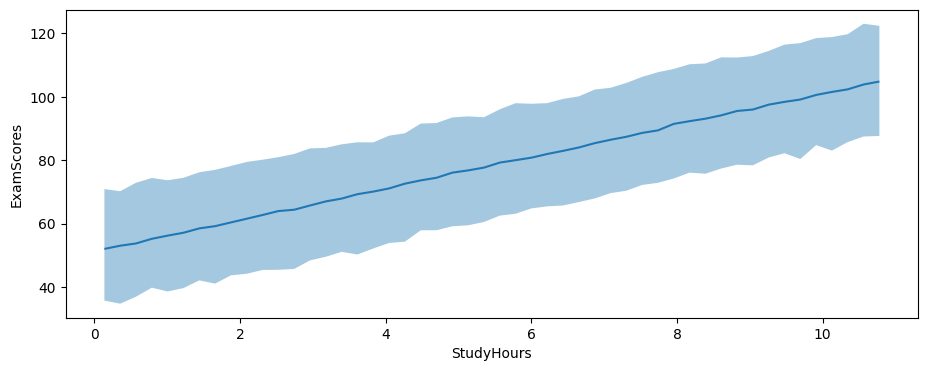

In [27]:
import pandas as pd
import numpy as np
import bambi as bmb
import matplotlib.pyplot as plt


# Define the model
model_study = bmb.Model("ExamScores ~ StudyHours", data=data)

# Fit the model
idata_study = model_study.fit(idata_kwargs={'log_likelihood': True})

_, ax = plt.subplots(figsize=(11, 4))

# Plot the predictions
bmb.interpret.plot_predictions(model_study,
                               idata_study,
                               "StudyHours",  # Predicting based on Study Hours
                               fig_kwargs={"figsize": (11, 4)},  # Figure size
                               pps=True,  # Add HDIs for posterior predictive samples
                               ax=ax)  # Pass axis for plotting

# Show the plot
plt.show()



This code creates a model to predict exam scores based on sudy hours, fits the model to th data, an then vsualizes the redicions. It plots the expected exam scores along with a 94% Highest Density Interval (HDI), which shws the rage where most predicted values fall. The graph helps us see the relationship between stdy time and exam performance while achgcounting for unceranty in the phudictions.

##interaction effect with all quantiative variables

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


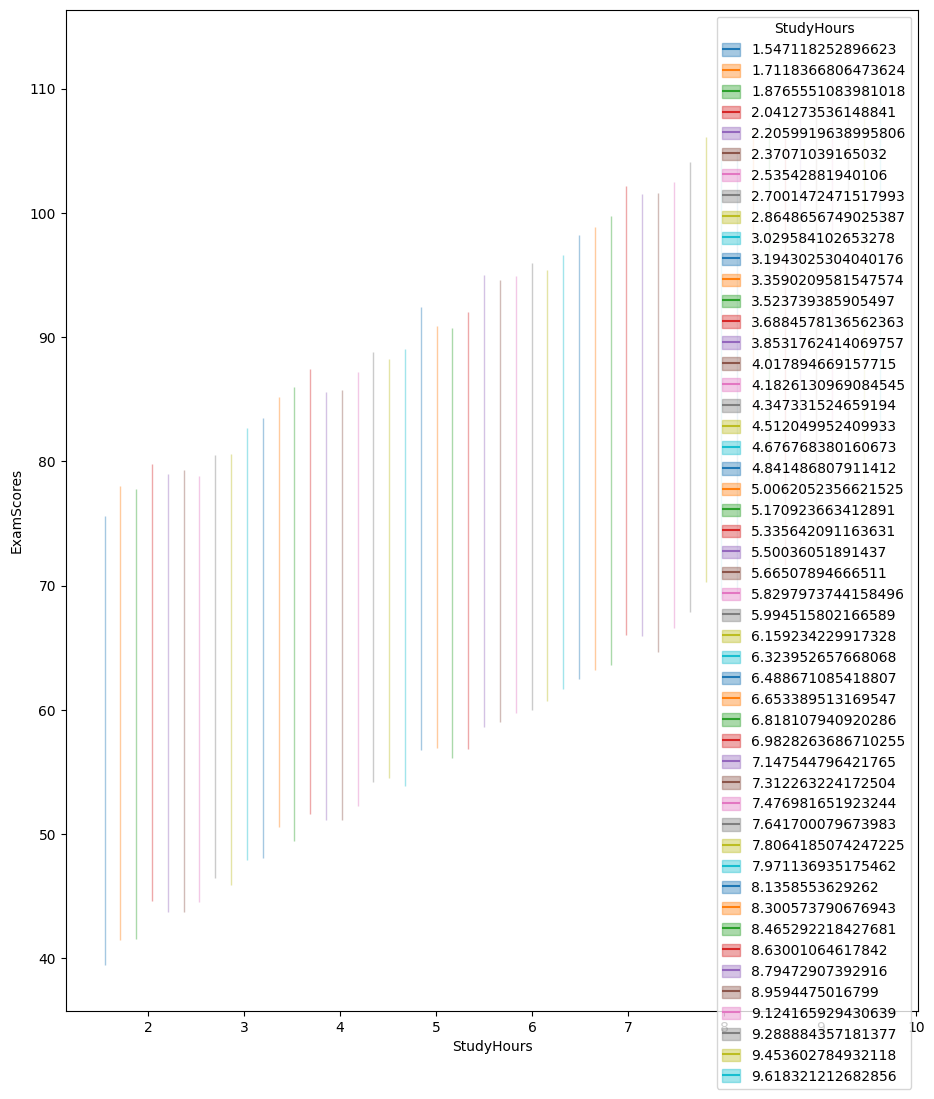

In [28]:
import pandas as pd
import numpy as np
import bambi as bmb
import matplotlib.pyplot as plt

# Load the study data
study_hours = np.random.normal(5, 1.5, 100)
exam_scores = 50 + (study_hours * 5) + np.random.normal(0, 10, 100)

data = pd.DataFrame({"StudyHours": study_hours, "ExamScores": exam_scores})

# Define the model with an interaction term (like you had with `FT%` and `3PA` for basketball)
model_study_interaction = bmb.Model("ExamScores ~ StudyHours + StudyHours:StudyHours", data=data)

# Fit the model
idata_study_interaction = model_study_interaction.fit(idata_kwargs={'log_likelihood': True})

# Plotting the 94% HDIs of the predicted exam scores based on study hours with interaction
_, ax = plt.subplots(figsize=(11, 13))

bmb.interpret.plot_predictions(model_study_interaction,
                               idata_study_interaction,
                               ["StudyHours", "StudyHours"],  # Interaction term for Study Hours
                               fig_kwargs={"figsize": (11, 13)},  # Figure size
                               pps=True,  # Add HDIs for posterior predictive samples
                               ax=ax)  # Pass axis for plotting

# Show the plot
plt.show()


This model is ued to predict exam scores based on stud hours, including an interaction ter where study hours are multiplied by themselvesto account for possible nonlinear effects. Aftr fitting the model, it isualizes hthe predictions with a 94% Highst Density Ihntervl (HDI), showing theexpected range of exam sors for different study times. This helps determine if the effect of stuying follows a straight-line trendor if there's a curve, meaning extra studying might have iminishing orincreasing returnis

###Conclusion and Prediction

The model shows that, on average, an increase in study hours is asociated with higher exam scoes. This relationship is influnced by a mix of prio belies (priors for α and β) and the observed data, wich helps usunderstand the underlying trend. However, with the uncertainty intervals drived from the posterior predictiv check, we can predict tht future students' exam scores will likely follow the same general trend of improvement with increased study time, though with variability. This variabiliy depends on ndividual fctors like study efficiency, external conditions, and personal earnig styles. Given the interaction term in the model, it’s possible that the effect of study hours on exam scores could change at dfferent levels of study ime, ndicating that simply ncreasing study time may not always lead to liear improvements. In ther words, beyond a certain point, additional study hours may not have as significant an efect on exam peformance, or cold even have diminishing returns depending on how effectivelystudents are studying. he model gies us a clearer picture of the relaionship between tudy hours and performance, but real-world factors may influence this outcome in ways the model can't fully cature.

